In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import math
# importar future
from __future__ import print_function

c:\Users\Felipe de Jesus\miniconda3\envs\MLearn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class WeatherData(Dataset):
    def __init__(self,future=0):
        self.data = pd.read_csv('Data/raw_data_sinaica.csv')
        #self.data = self.data.dropna()
        # rellenar los datos con promedios moviles o interpolaciones
        self.data = self.data.interpolate()
        self.data['Time'] = pd.to_datetime(self.data['Time'])
        self.data = self.data.sort_values(by=['Estación','Time'])
        self.data = self.data.set_index('Time')
        self.Municipios = self.data['Estación'].unique()
        self.Mundicc = {}
        # hacer un diccionario para el nombre de los municipios
        for i in range(len(self.Municipios)):
            self.Mundicc[self.Municipios[i]] = i
        # Aplicar el diccionario al dataframe
        self.data['Estación'] = self.data['Estación'].map(self.Mundicc)
        for col in self.data.columns:
            self.data = self.data[self.data[col]>=0]
        # numpy array
        # agarrar solo datos de la estacion 0
        self.data = self.data[self.data['Estación'] == 0]
        # quitar columna estacíon
        self.data = self.data.drop(columns=['Estación'])
        self.columns = self.data.columns
        # standarizar los datos
        self.mean = self.data.mean()
        self.std = self.data.std()
        self.data = (self.data - self.mean)/self.std
        # correjir los NaN
        self.data = self.data.fillna(0)
        self.data = self.data.to_numpy()
        # convertir los numeros menores a 0 en 
        self.x = torch.tensor(self.data[:-1], dtype=torch.float)
        self.y = torch.tensor(self.data[1:], dtype=torch.float)
        self.set_future(future)
    def set_future(self, future):
        self.future = future
    def __len__(self):
        return len(self.data)-self.future-1

    def __getitem__(self, idx):
        return self.x[idx].unsqueeze(0),self.y[idx].unsqueeze(0)
    def get_batch(self, batch_size, future = 0):
        idx = np.random.randint(0, len(self.data)-future-1, batch_size)
        return self.x[idx],self.y[idx+future]

In [3]:
def LinearCell(num_input, num_hidden, Dropout=0.1):
    Seq = nn.Sequential(
        nn.Linear(num_input,num_hidden),
        nn.LeakyReLU(0.8),
        nn.Dropout(Dropout)
    )
    return Seq

In [4]:
# Try to define the weights of a network with the diagonal = 0
# and the rest of the weights = 1
# define a function that recibe the matrix of weights and make the diagonal = 0
def diag_zero(matrix, value = 0, with_double = False, Wrap = False):
    if Wrap == False:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if i == j:
                    matrix[i][j] = value
        # the other side diagonal
        if with_double:
            for i in range(matrix.shape[0]):
                for j in range(matrix.shape[1]):
                    if matrix.shape[0] - i -1 == j:
                        matrix[i][j] = value
    else:
        matrix = matrix.numpy().T
        np.fill_diagonal(matrix, value, wrap=True)
        matrix = torch.from_numpy(matrix.T)
    return matrix

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [6]:

class Net(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers, num_linear =1,max_len = 20):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.max_len = max_len
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers)
        self.attn = nn.Linear(hidden_size*2, max_len)
        self.softmax = nn.Softmax(dim=2)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        LinearSeq = []
        for i in range(num_linear):
            LinearSeq.append(LinearCell(hidden_size,hidden_size))
        self.LinearSeq = nn.Sequential(*LinearSeq)
        self.L1 = LinearCell(hidden_size,hidden_size)
        self.L2 = LinearCell(hidden_size,hidden_size)
        self.LOut = LinearCell(hidden_size,output_size)
        self.init_weights()
    def init_weights(self):
        count_linear = 0
        for m in self.modules():
            if isinstance(m, nn.Linear):
                count_linear += 1
                nn.init.xavier_normal_(m.weight)
                m.weight.data = diag_zero(m.weight.data, value = 0.3*math.sqrt(count_linear), with_double = True, Wrap = True)
                nn.init.normal_(m.bias)
    def forward(self,x,future=0):
        # outputs
        outputs = []
        outputs_attn = torch.zeros(x.size(1),self.max_len,self.hidden_size)
        h_t = torch.zeros(self.num_layers,1,self.hidden_size)
        c_t = torch.zeros(self.num_layers,1,self.hidden_size)
        
        for input_t in x.split(1,dim=0):
            out, (h_t,c_t) = self.lstm1(input_t,(h_t,c_t))
            cat = torch.cat((out,c_t[0:1]),dim=2)
            attn_weights = self.attn(cat)
            attn_weights = self.softmax(attn_weights)
            attn_applied = torch.bmm(attn_weights,outputs_attn)
            cat = torch.cat((out,attn_applied),dim=2)
            out = self.attn_combine(cat)
            out = self.LinearSeq(out)
            l1 = self.L1(out)
            l2 = self.L2(l1)
            output = self.LOut(l2)
            outputs_attn = torch.cat ((l2,outputs_attn[:,:-1,:]),dim=1)
            outputs.append(output)
        
        for i in range(future):
            out, (h_t,c_t) = self.lstm1(output, (h_t,c_t))
            cat = torch.cat((out,c_t[0:1]),dim=2)
            attn_weights = self.attn(cat)
            attn_weights = self.softmax(attn_weights)
            attn_applied = torch.bmm(attn_weights,outputs_attn)
            cat = torch.cat((out,attn_applied),dim=2)
            out = self.attn_combine(cat)
            out = self.LinearSeq(out)
            l1 = self.L1 (out)
            l2 = self.L2(l1)
            output = self.LOut(l2)
            outputs_attn = torch.cat ((l2,outputs_attn[:,:-1,:]),dim=1)
            outputs.append(output)
        outputs = torch.cat(outputs,dim=0)
        return outputs

In [17]:
# pararmetros del entrenamiento
learning_rate = .001
num_epochs = 50
batch_size = 180
clip = .5
future = 80
Prediction_weight = 1.2
dataset = WeatherData()
Batch_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [8]:
input_size = dataset.columns.__len__()
max_lenght = 24*3
argument = {
    'input_size' : input_size,
    'hidden_size' : 32,
    'output_size' : input_size,
    'num_layers' : 3,
    'num_linear' : 2,
    'max_len' : max_lenght
}
Predictor = Net(**argument)
criterion = nn.MSELoss()


In [9]:
optimizer = torch.optim.Adam(Predictor.parameters(), lr=learning_rate)

In [10]:
sample_t = torch.zeros(1,1,input_size)
output = Predictor(sample_t)
print (output.shape)

torch.Size([1, 1, 15])


In [31]:
from tqdm  import tqdm
import matplotlib.pyplot as plt

def test(Predictor,test_data,size,future=60,it = 0):
    iterat = DataLoader(test_data, batch_size=size, shuffle=False)
    iterat = iter(iterat)
    for i in range(it):
        (x,y) = next(iterat)
    out = Predictor(x[:-future],future=future)
    Y_proyectado = out.detach().numpy()[:,0,0]
    Y_real = y.detach().numpy()[:,0,0]
    plt.plot(Y_real,label='Real')
    plt.plot(Y_proyectado,label='Prediccion')
    plt.axvline(x=size-future, color='black', linestyle='--')
    plt.legend()
    plt.show()

In [13]:
#min_loss = 0.24296
min_loss = .25

In [14]:
#del loss_list
loss_list = []

In [15]:
# load checkpoint
Predictor.load_state_dict(torch.load('Model/Checkpoint3.pt'))

<All keys matched successfully>

Epoch: 0 Loss: 0.24824:   0%|          | 0/450 [00:08<?, ?it/s]

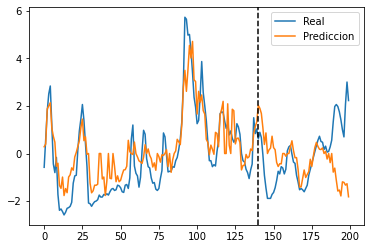

Epoch: 3 Loss: 0.24277:   1%|          | 3/450 [00:36<1:07:58,  9.12s/it]

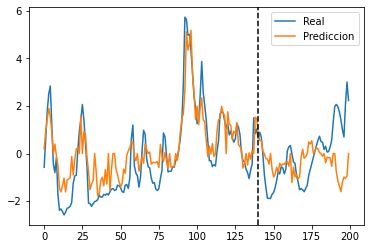

Epoch: 6 Loss: 0.24371:   1%|▏         | 6/450 [01:11<1:22:05, 11.09s/it]

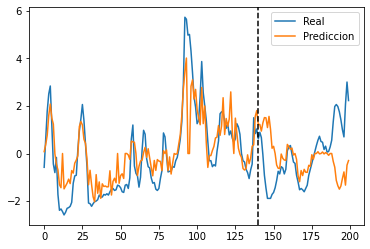

Epoch: 9 Loss: 0.24512:   2%|▏         | 9/450 [01:38<1:11:08,  9.68s/it]

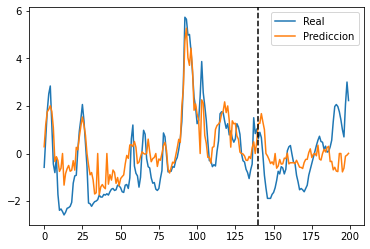

Epoch: 12 Loss: 0.24190:   3%|▎         | 12/450 [02:04<1:06:09,  9.06s/it]

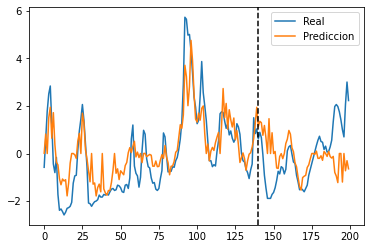

Epoch: 15 Loss: 0.24364:   3%|▎         | 15/450 [02:31<1:04:30,  8.90s/it]

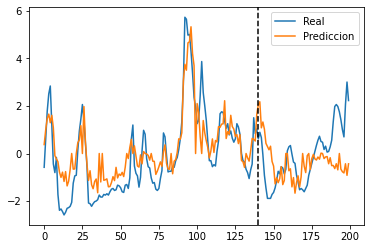

Epoch: 18 Loss: 0.24548:   4%|▍         | 18/450 [02:57<1:03:31,  8.82s/it]

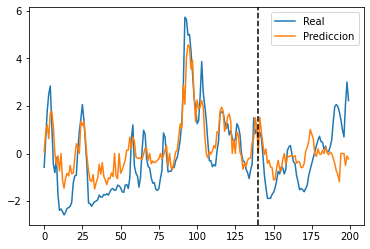

Epoch: 21 Loss: 0.24680:   5%|▍         | 21/450 [03:24<1:02:51,  8.79s/it]

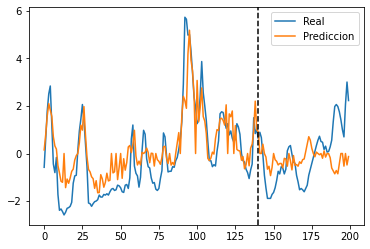

Epoch: 24 Loss: 0.24599:   5%|▌         | 24/450 [03:50<1:02:21,  8.78s/it]

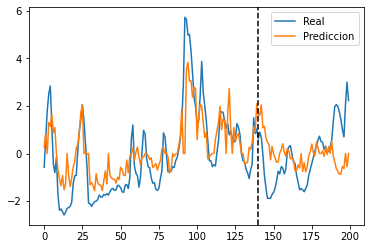

Epoch: 27 Loss: 0.24285:   6%|▌         | 27/450 [04:17<1:02:23,  8.85s/it]

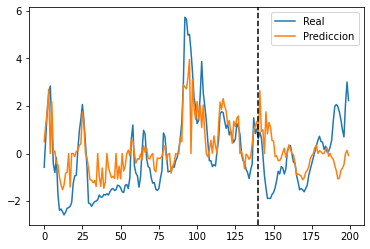

Epoch: 30 Loss: 0.24616:   7%|▋         | 30/450 [04:44<1:02:26,  8.92s/it]

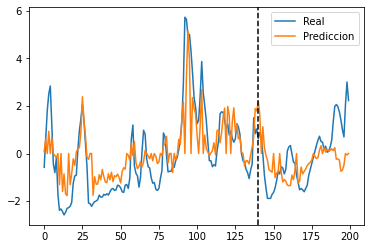

Epoch: 33 Loss: 0.24406:   7%|▋         | 33/450 [05:10<1:00:47,  8.75s/it]

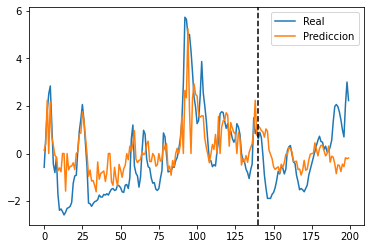

Epoch: 36 Loss: 0.23860:   8%|▊         | 36/450 [05:37<1:01:23,  8.90s/it]

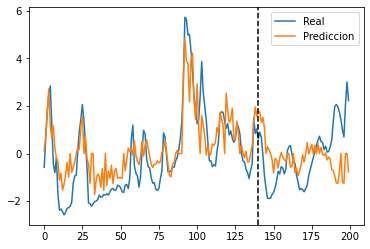

Epoch: 39 Loss: 0.23935:   9%|▊         | 39/450 [06:07<1:03:39,  9.29s/it]

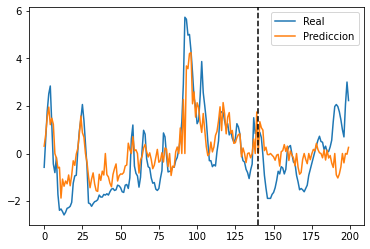

Epoch: 42 Loss: 0.24072:   9%|▉         | 42/450 [06:51<1:21:23, 11.97s/it]

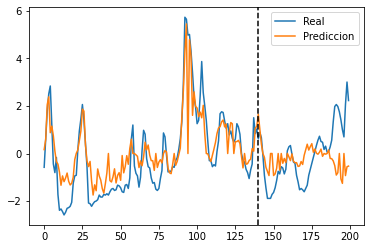

Epoch: 45 Loss: 0.23926:  10%|█         | 45/450 [07:31<1:33:17, 13.82s/it]

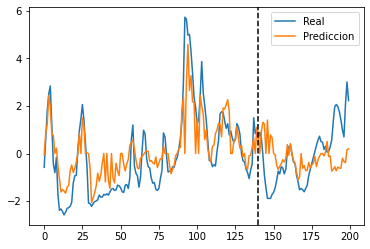

Epoch: 47 Loss: 0.23894:  11%|█         | 48/450 [07:53<1:06:08,  9.87s/it]


KeyboardInterrupt: 

In [18]:
# set learning rate
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.0005
progress = tqdm(range(num_epochs+400))
for epoch in progress:
    mean_loss = 0.0
    for _,(x,y) in enumerate(Batch_loader):
        #print (x.shape)
        if x.shape[0] < batch_size:
            continue
        #print (y.shape)
        out = Predictor(x[:-future],future=future)
        teached_out = out[:-future]
        predicted_out = out[-future:]
        teached_loss = criterion(teached_out,y[:-future])
        predicted_loss = criterion(predicted_out,y[-future:])
        loss = ((teached_loss*0.4) + (predicted_loss * 0.6)) / 2
        if torch.cuda.is_available():
            loss = loss.cuda()
        mean_loss += loss
    mean_loss = mean_loss / len(Batch_loader)
    optimizer.zero_grad()
    mean_loss.backward()
    #torch.nn.utils.clip_grad_norm_(Predictor.parameters(), clip)
    optimizer.step()
    progress.set_description("Epoch: {} Loss: {:.5f}".format(epoch,mean_loss.item()))
    loss_list.append(mean_loss.item())
    if mean_loss.item() < min_loss and mean_loss.item() > 0:
        min_loss = mean_loss.item()
        # save checkpoint
        print ('Mejor modelo guardado')
        torch.save(Predictor.state_dict(), 'Model/Checkpoint3.pt')

    if epoch % 3 == 0:
        test(Predictor,dataset,200,future=60)

In [19]:
print ('Minimo Loss: ',min_loss)

Minimo Loss:  0.22667793929576874


In [20]:
# guardar el modelo
torch.save(Predictor.state_dict(), 'Model/modelApodacaAttentionDiag.pt')

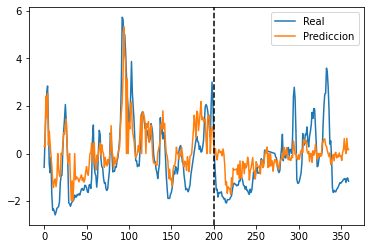

In [51]:
context = 200 
pred = 160
test(Predictor,dataset,context+pred,future=pred,it=1)

In [57]:
# make a function to predict same as test, but generate 100 generations and print the mean and std
def predict(Predictor,test_data,size,future=60,it = 0, gens = 100):
    iterat = DataLoader(test_data, batch_size=size, shuffle=False)
    iterat = iter(iterat)
    for i in range(it):
        (x,y) = next(iterat)
    outputs = []
    for i in range(gens):
        out = Predictor(x[:-future],future=future)
        Y_proyectado = out.detach().numpy()[:,0,0]
        outputs.append(Y_proyectado)
        Y_real = y.detach().numpy()[:,0,0]
    outputs = np.array(outputs)
    mean = outputs.mean(axis=0)
    std = outputs.std(axis=0)
    # dont print the results of the prediction before the axvline
    plt.plot(Y_real,label='Real')
    plt.plot(mean,label='Prediccion')
    plt.fill_between(np.arange(mean.shape[0]),mean-std,mean+std,alpha=0.5)
    plt.axvline(x=size-future, color='black', linestyle='--')
    plt.legend()
    plt.show()

In [1]:
predict(Predictor,dataset,210,future=70,it=6,gens=100)

NameError: name 'predict' is not defined